Exercise: *Try using a denoising autoencoder to pretrain an image classifier. You can use MNIST (the simplest option), or a more complex image dataset such as CIFAR10 if you want a bigger challenge.*

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

2024-04-14 19:16:07.878440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


a. *Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set.*

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

In [3]:
X_train.shape

(50000, 32, 32, 3)

In [4]:
tf.random.set_seed(42)
denoising_encoder = tf.keras.Sequential(
    [
        tf.keras.layers.GaussianNoise(0.1),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
    ]
)
denoising_decoder = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(16 * 16 * 32, activation="relu"),
        tf.keras.layers.Reshape([16, 16, 32]),
        tf.keras.layers.Conv2DTranspose(
            filters=3, kernel_size=3, strides=2, padding="same", activation="sigmoid"
        ),
    ]
)
denoising_ae = tf.keras.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["mse"])

2024-04-14 19:16:10.850505: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
from time import sleep

n_epochs = 10
for i in range(n_epochs):
    denoising_ae.fit(X_train, X_train, validation_data=(X_test, X_test))
    if i < n_epochs - 1:
        sleep(30)

1563/1563 [==============================] - 219s 140ms/step - loss: 0.5632 - mse: 0.0064 - val_loss: 0.5661 - val_mse: 0.0070


The training process is a bit long (nearly an hour), so I'll save the model for later use. 

In [6]:
tf.keras.models.save_model(denoising_ae, "my_denoising_ae_exercise_10")

2024-04-12 20:45:43.193502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gaussian_noise_input' with dtype float and shape [?,32,32,3]
	 [[{{node gaussian_noise_input}}]]
2024-04-12 20:45:43.220933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32,32,3]
	 [[{{node inputs}}]]
2024-04-12 20:45:43.228892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gaussian_noise_input' with dtype float and sh

INFO:tensorflow:Assets written to: my_denoising_ae_exercise_10/assets


INFO:tensorflow:Assets written to: my_denoising_ae_exercise_10/assets


In [13]:
denoising_ae = tf.keras.models.load_model("my_denoising_ae_exercise_10")

b. *Check that the images are fairly well reconstructed. Visualize the images that most activate each neuron in the coding layer.*

1/1 [==============================] - 0s 76ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


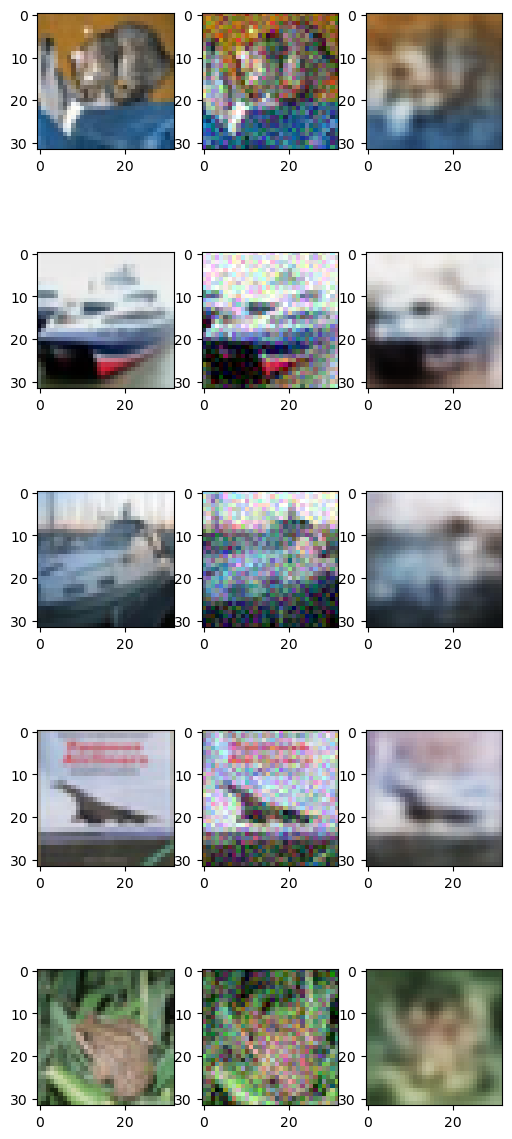

In [14]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + tf.random.normal([n_images, 32, 32, 3]) * 0.1
new_images_denoising = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 3))
for index in range(n_images):
    plt.subplot(n_images, 3, 3 * index + 1)
    plt.imshow(new_images[index])
    plt.subplot(n_images, 3, 3 * index + 2)
    plt.imshow(new_images_noisy[index])
    plt.subplot(n_images, 3, 3 * index + 3)
    plt.imshow(new_images_denoising[index])

c. *Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set. Does it perform better with or without pretraining?*

Pretend we have only 500 labeled images.

In [15]:
X_train = X_train[:500]
y_train = y_train[:500]

I will try 3 models, all three with the same architecture, by adding an output layer on top of the encoder: One without pretraining, one with pretraining and freezing, one with pretraining and not freezing.

We will all compile them with Nadam optimizer, and train for 20 epochs.

In [16]:
model_without_pretrain = tf.keras.Sequential(
    [
        tf.keras.layers.GaussianNoise(0.1),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)
model_without_pretrain.compile(
    loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]
)
model_without_pretrain.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_test, y_test),
)

Epoch 1/20
16/16 [==============================] - 7s 401ms/step - loss: 2.6433 - accuracy: 0.1340 - val_loss: 2.2384 - val_accuracy: 0.1553
Epoch 2/20
16/16 [==============================] - 7s 430ms/step - loss: 2.1281 - accuracy: 0.2100 - val_loss: 2.0883 - val_accuracy: 0.2271
Epoch 3/20
16/16 [==============================] - 7s 487ms/step - loss: 1.9192 - accuracy: 0.3180 - val_loss: 2.0276 - val_accuracy: 0.2415
Epoch 4/20
16/16 [==============================] - 5s 357ms/step - loss: 1.7843 - accuracy: 0.4000 - val_loss: 2.0174 - val_accuracy: 0.2591
Epoch 5/20
16/16 [==============================] - 6s 368ms/step - loss: 1.6801 - accuracy: 0.4080 - val_loss: 1.9924 - val_accuracy: 0.3021
Epoch 6/20
16/16 [==============================] - 5s 339ms/step - loss: 1.5680 - accuracy: 0.4760 - val_loss: 1.9383 - val_accuracy: 0.2963
Epoch 7/20
16/16 [==============================] - 5s 356ms/step - loss: 1.4767 - accuracy: 0.4920 - val_loss: 1.8385 - val_accuracy: 0.3361
Epoch 

In [17]:
denoising_encoder, denoising_decoder = denoising_ae.layers
model_with_unfreeze_pretrain = tf.keras.Sequential(
    [denoising_encoder, tf.keras.layers.Dense(10, activation="softmax")]
)
model_with_unfreeze_pretrain.compile(
    optimizer="nadam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model_with_unfreeze_pretrain.fit(
    X_train, y_train, epochs=20, validation_data=(X_test, y_test)
)

Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 2.4673 - accuracy: 0.1380

16/16 [==============================] - 7s 423ms/step - loss: 2.4673 - accuracy: 0.1380 - val_loss: 2.1993 - val_accuracy: 0.1955
Epoch 2/20
16/16 [==============================] - 4s 256ms/step - loss: 2.0160 - accuracy: 0.2780 - val_loss: 2.0759 - val_accuracy: 0.2667
Epoch 3/20
16/16 [==============================] - 4s 259ms/step - loss: 1.7458 - accuracy: 0.4140 - val_loss: 2.0159 - val_accuracy: 0.2892
Epoch 4/20
16/16 [==============================] - 4s 240ms/step - loss: 1.4999 - accuracy: 0.4820 - val_loss: 1.9218 - val_accuracy: 0.3212
Epoch 5/20
16/16 [==============================] - 5s 302ms/step - loss: 1.2866 - accuracy: 0.5500 - val_loss: 1.9073 - val_accuracy: 0.3292
Epoch 6/20
16/16 [==============================] - 4s 272ms/step - loss: 1.0649 - accuracy: 0.6580 - val_loss: 1.8920 - val_accuracy: 0.3511
Epoch 7/20
16/16 [==============================] - 5s 298ms/step - loss: 0.8934 - accuracy: 0.7420 - val_loss: 1.8620 - val_accuracy: 0.3505
Epoch 8/20
16/16 

In [18]:
denoising_encoder.trainable = False
model_with_freeze_pretrain = tf.keras.Sequential(
    [denoising_encoder, tf.keras.layers.Dense(10, activation="softmax")]
)
model_with_freeze_pretrain.compile(
    optimizer="nadam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model_with_freeze_pretrain.fit(
    X_train, y_train, epochs=20, validation_data=(X_test, y_test)
)

Epoch 1/20
16/16 [==============================] - 7s 443ms/step - loss: 4.9225 - accuracy: 0.0900 - val_loss: 3.0425 - val_accuracy: 0.1088
Epoch 2/20
16/16 [==============================] - 4s 275ms/step - loss: 2.7764 - accuracy: 0.1600 - val_loss: 2.7605 - val_accuracy: 0.1608
Epoch 3/20
16/16 [==============================] - 6s 392ms/step - loss: 2.3281 - accuracy: 0.2320 - val_loss: 2.5603 - val_accuracy: 0.2044
Epoch 4/20
16/16 [==============================] - 5s 357ms/step - loss: 1.9712 - accuracy: 0.3140 - val_loss: 2.3803 - val_accuracy: 0.2277
Epoch 5/20
16/16 [==============================] - 5s 319ms/step - loss: 1.7013 - accuracy: 0.3980 - val_loss: 2.3249 - val_accuracy: 0.2550
Epoch 6/20
16/16 [==============================] - 4s 250ms/step - loss: 1.4637 - accuracy: 0.4920 - val_loss: 2.2666 - val_accuracy: 0.2661
Epoch 7/20
16/16 [==============================] - 5s 321ms/step - loss: 1.2872 - accuracy: 0.5640 - val_loss: 2.2129 - val_accuracy: 0.2862
Epoch 

The first thing to notice here is the models turn out to be too powerful: All three of them start to overfit the training set after about 10 epochs. Since we add only one layer on top of the encoder, the model with freeze pretrained has the worst score on the train set, but turn out to be the best on validation. The model with unfreeze pretrained layer reached the best score on the train set. The model with no pretrain fall short in both the train and valid sets.

My conclusion: You should reuse the pretrain layers. If you have plenty of training instances, train the whole model as usual, and the training process will speed up considerably. In this case though, 500 images is not so much, hence you should freeze the pretrained layers and more importantly, train it on a small number of epochs (e.g., 10 epochs), or else your model will severely overfit the training set.